In [1]:
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.feature   as cfeature
import cartopy.crs       as ccrs
import numpy             as np
import pandas            as pd
import xarray            as xr
import cartopy.feature   as cfeature
import cartopy.crs       as ccrs
import netCDF4
import math
import yaml
import sys
import os

from   pylab             import cm
from   scipy             import ndimage
from numpy               import inf

NaN = np.nan
import warnings
warnings.filterwarnings("ignore")

sys.path.append('/home/veilleux/Projet/Projet_SACHR/analyses_and_figures/python_modules')
from domain         import generate_domain_coord
from domain         import convert_latlon_to_domain_indices
from satellite      import extract_satellite_track

# PLOT TESTS

In [2]:
dpi = 150
data_dir = 'pampa/poitras/DATA'
gemname              = "COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes"
# Step 0 GEM path to set lat and lon in cartopy
step_0 = "COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes_step0"
ncfile = '/{}/GEM5/{}/Samples_NetCDF/{}/pm2013010100_00000000p.nc'.format(data_dir,gemname,step_0)

# Get lat, lon and cartopy_projection_object
ds  = xr.open_dataset(ncfile) # Dataframe from the netcdf file
lat = ds.lat.values           # 2D array with latitude
lon = ds.lon.values           # 2D array with longitude
m   = ccrs.RotatedPole(ds.rotated_pole.grid_north_pole_longitude, ds.rotated_pole.grid_north_pole_latitude)
xll, yll = m.transform_point(lon[ 0,  0],lat[ 0,  0], ccrs.PlateCarree())
xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())
L0_country_ALL = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')

def plot_map_tracks(tot_cover, high_cover, mid_cover, low_cover):
    fig = plt.figure(figsize=(15, 15), constrained_layout = True)
    ##########################################################################################################
    ###                                    Creating a discrete colorbar                                    ###
    ##########################################################################################################
    # Discrete colors                                                                                      ###
    cm = plt.get_cmap('viridis', 10)                                                                       ###
    #cm = plt.get_cmap('seismic', 11)                                                                      ###
    # Discrete color increment values                                                                      ###
    bounds_maps  = np.linspace(0, 1, 11)                                                                   ###                                                                  
    #bounds_maps  = np.linspace(-1, 1, 11)                                                                 ###                                                                  
    # Norm                                                                                                 ###
    norm_maps    = mpl.colors.BoundaryNorm(bounds_maps, cm.N)                                              ###
    ##########################################################################################################

    #############################
    ###        MODIS          ###
    #############################

    ###########################################################################
    l1 = 0.02; l2 = 0.26; l3 = 0.50 ;l4= 0.74                               ### 
    h  = 0.23; w  = 0.23 # h = height, w = width of the subplots (fraction) ###
    b  = 0.73            # b = bottom height                                ###
    fs = 13              # Fontsize for titles                              ###
    ###########################################################################
    # First subplot
    ax1 = plt.axes([l1, b, w, h],projection=m)
    ax1.set_extent([xll, xur, yll, yur], crs = m)
    ax1.set_title('Total Cloud Cover', fontsize = 20)
    ax1.coastlines()
    ax1.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
    MODIS_t = ax1.pcolormesh(lon, lat,tot_cover, cmap=cm, transform=ccrs.PlateCarree(), norm = norm_maps)

    # Second subplot
    ax2 = plt.axes([l2, b, w, h],projection=m)
    ax2.set_extent([xll, xur, yll, yur], crs = m)
    ax2.set_title('High Cloud Cover', fontsize = 20)
    ax2.coastlines()
    ax2.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
    ax2.pcolormesh(lon, lat,high_cover, cmap=cm, transform=ccrs.PlateCarree(), norm = norm_maps)

    # Third subplot
    ax3 = plt.axes([l3, b, w, h],projection=m)
    ax3.set_extent([xll, xur, yll, yur], crs = m)
    ax3.set_title('Mid Cloud Cover', fontsize = 20)
    ax3.coastlines()
    ax3.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
    ax3.pcolormesh(lon, lat, mid_cover, cmap=cm, transform=ccrs.PlateCarree(), norm = norm_maps)

    # Fourth subplot
    ax4 = plt.axes([l4, b, w, h],projection=m)
    ax4.set_extent([xll, xur, yll, yur], crs = m)
    ax4.set_title('Low Cloud Cover', fontsize = 20)
    ax4.coastlines()
    ax4.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
    ax4.pcolormesh(lon, lat, low_cover, cmap=cm, transform=ccrs.PlateCarree(), norm = norm_maps)

    #############################
    ###   Colorbar setting    ###
    #############################
    cb_l = 0.98
    #Colorbar             # [left,bottom,width,height]
    cbar_ax1 = fig.add_axes([cb_l, 0.73, 0.01, 0.23])
    cbar1    = fig.colorbar(MODIS_t, extend = 'neither', cax = cbar_ax1, ticks=bounds_maps, boundaries=bounds_maps)
    cbar1.ax.tick_params(labelsize=15)

    # Adjust the layout and display the plot
    plt.show()
    plt.close()

# CONFIG FILES WITH DIRECTORY

In [3]:
working_directory = '/home/veilleux/Projet/Projet_SACHR/analyses_and_figures/1_CALIPSO_LowMidHigh_cloudcover'
yml_file = working_directory + '/../config.yml'
stream = open(yml_file,'r')
config = yaml.safe_load(stream)

dirlist = config['CALIPSO_CHINOOK']['list']

# FUNCTIONS

In [8]:
def compute_cloud_cover(ncfilei, layerdef):
    
    nc = netCDF4.Dataset(ncfilei,'r')
    tca_COSP  = nc['tca'][:]  # Total cloud area
    Pressure  = nc['pfull'][:]/100
    
    # Altitude and pressure limit for High, Mid, Low layer. See eg: https://climserv.ipsl.polytechnique.fr/cfmip-obs/Calipso_goccp.html '''
    pressure_lim_midlow  =  680 # hPa
    pressure_lim_midhigh =  440 # hPa

    # Création de masques pour garder les points du profile pour une couche donnée (Low,Mid,High)'''    
    mask_high = np.where(Pressure <  pressure_lim_midhigh,  1, NaN)
    mask_low  = np.where(Pressure >= pressure_lim_midlow ,  1, NaN)
    mask_mid  = np.where(Pressure >= pressure_lim_midhigh,  1, NaN) * np.where(Pressure < pressure_lim_midlow , 1, NaN)

    # Applying cloud mask
    Cloud_Layer_Fraction      = tca_COSP    
    Cloud_Layer_Fraction_high = Cloud_Layer_Fraction * mask_high
    Cloud_Layer_Fraction_mid  = Cloud_Layer_Fraction * mask_mid
    Cloud_Layer_Fraction_low  = Cloud_Layer_Fraction * mask_low
    
    #######################################################################################
    #######################################################################################
    #######################################################################################
    
    def subtract(z):
        return 1 - z 
    subtract_vec = np.vectorize(subtract) # Vectorizing function

    def random_overlap(array):
        return 1 - np.nanprod(array, axis = 0)
    
    if 'max' in layerdef:
        Cloud_Cover      = np.nanmax(Cloud_Layer_Fraction     ,axis=0)                                                             
        Cloud_Cover_high = np.nanmax(Cloud_Layer_Fraction_high,axis=0)
        Cloud_Cover_mid  = np.nanmax(Cloud_Layer_Fraction_mid ,axis=0)
        Cloud_Cover_low  = np.nanmax(Cloud_Layer_Fraction_low ,axis=0)
        plot_map_tracks(Cloud_Cover,Cloud_Cover_high,Cloud_Cover_mid,Cloud_Cover_low)

    elif 'ran' in layerdef:
        # 1 - C_ij
        Total_Cover      = subtract_vec(Cloud_Layer_Fraction     )
        High             = subtract_vec(Cloud_Layer_Fraction_high)
        Mid              = subtract_vec(Cloud_Layer_Fraction_mid )
        Low              = subtract_vec(Cloud_Layer_Fraction_low )
        #Cloud covers
        Cloud_Cover      = random_overlap(Total_Cover)                                                             
        Cloud_Cover_high = random_overlap(High       )
        Cloud_Cover_mid  = random_overlap(Mid        )
        Cloud_Cover_low  = random_overlap(Low        )
        plot_map_tracks(Cloud_Cover,Cloud_Cover_high,Cloud_Cover_mid,Cloud_Cover_low)
  
    return Cloud_Cover, Cloud_Cover_high, Cloud_Cover_mid, Cloud_Cover_low


def create_ouput_file(ncfilei,ncfileo,Tot_cloud_cover, High_cloud_cover, Mid_cloud_cover, Low_cloud_cover, layerdef):
    pressure_lim_midlow  =  680 # hPa
    pressure_lim_midhigh =  440 # hPa

    # I/O file 
    if     os.path.exists(ncfileo)                 : os.remove(ncfileo)
    if not os.path.exists(os.path.dirname(ncfileo)): os.makedirs(os.path.dirname(ncfileo))
    nci = netCDF4.Dataset(ncfilei, 'r');
    nco = netCDF4.Dataset(ncfileo, 'w');

    # New data to output 
    newvarnames = [ 'Tot_cloud_cover', 'High_cloud_cover', 'Mid_cloud_cover', 'Low_cloud_cover']
    # Old data to copy
    varnames    = [ 'latitude', 'longitude' ]
    
    # Extracting the dimensions
    dimnames = []
    for varname in varnames:
        for dimname in nci.variables[varname].dimensions:
            if 'level' in varname:
                pass
            else:
                dimnames.append(dimname)
    dimnames = set(dimnames)
    # Copying global attributes
    nco.setncatts(nci.__dict__)

    ''' Copying dimensions '''
    #dimnames = [dim for dim in nci.dimensions]
    for dimname in dimnames:
        dimension = nci.dimensions[dimname]
        print(dimension)
        nco.createDimension(dimname, (len(dimension) if not dimension.isunlimited() else None))

    ''' Copying (old) variables '''
    for varname in varnames:
        variable = nci[varname]
        x = nco.createVariable(varname, variable.datatype, variable.dimensions, zlib=True, complevel=4)
        nco[varname].setncatts(variable.__dict__)
        nco[varname][:] = nci[varname][:]

    ''' Long_name for the new variable'''
    if    'max'  in layerdef: str_layerdef     = 'maximum overlap'
    elif  'min'  in layerdef: str_layerdef     = 'minimum overlap'
    elif  'ran'  in layerdef: str_layerdef     = 'random overlap'
    elif  'mean' in layerdef: str_layerdef     = 'mean value'
    if layerdef[0] == 'p':
        long_name_Tot  = 'Total cloud cover: %s (all layers)'                     % (str_layerdef)
        long_name_High = 'High cloud cover : %s (layers with p < %dha)'           % (str_layerdef, pressure_lim_midhigh)
        long_name_Mid  = 'Mid cloud cover  : %s (layers with %dhPa > p >= %dhPa)' % (str_layerdef, pressure_lim_midlow, pressure_lim_midhigh)
        long_name_Low  = 'Low cloud cover  : %s (layers with p >= %dhPa)'         % (str_layerdef, pressure_lim_midlow)
    elif layerdef[0] == 'a':
        long_name_Tot  = 'Total cloud cover: %s (all layers)'                     % (str_layerdef)
        long_name_High = 'High cloud cover : %s (layers with h > %dm)'            % (str_layerdef, altitude_lim_midhigh)
        long_name_Mid  = 'Mid cloud cover  : %s (layers with %dm < h <= %dm )'    % (str_layerdef, altitude_lim_midlow, altitude_lim_midhigh)
        long_name_Low  = 'Low cloud cover  : %s (layers with h <= %dm)'           % (str_layerdef, altitude_lim_midlow)


    ''' Writting new variables '''
    for varname in newvarnames:

        if   varname ==  'Tot_cloud_cover' : data =  Tot_cloud_cover; long_name = long_name_Tot
        elif varname == 'High_cloud_cover' : data = High_cloud_cover; long_name = long_name_High
        elif varname ==  'Mid_cloud_cover' : data =  Mid_cloud_cover; long_name = long_name_Mid
        elif varname ==  'Low_cloud_cover' : data =  Low_cloud_cover; long_name = long_name_Low
        
        x = nco.createVariable(varname, 'float32',('lat','lon'), zlib=True, complevel=4)
        print(x)
        nco[varname].setncatts({'long_name': long_name})
        nco[varname][:] = data[:]


# SELECTION PERIOD AND LAYERDEF

In [10]:
period   = 'DJF'
layerdef = 'pmax'
if   period == 'DJF'   : months = [ 1,  2, 12]
elif period == 'MAM'   : months = [ 3,  4,  5]
elif period == 'JJA'   : months = [ 6,  7,  8]
elif period == 'SON'   : months = [ 9, 10, 11]
elif period == 'ANNUAL': months = [ 1,  2,  3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
else:                    months = [ int(period) ]


### COMPLETE filelist 2014-2015
filelist   = dirlist + '/' + '2014_2015.txt'
df         = pd.read_csv(filelist,delimiter='\s+', header=None)
df.columns = ['file', 'ndata', 'ti', 'tf', 'date', 'MM', 'date_gem', 't_gem']
df         = df[   np.isin(df['MM'], months)  ].reset_index(drop=True)

dirout  = config['GEM5_CHINOOK']['NetCDF'] + '_LowMidHigh/' + layerdef


if not os.path.exists(dirout): os.makedirs(dirout)

# ITERATE OVER ALL TIMESTEPS

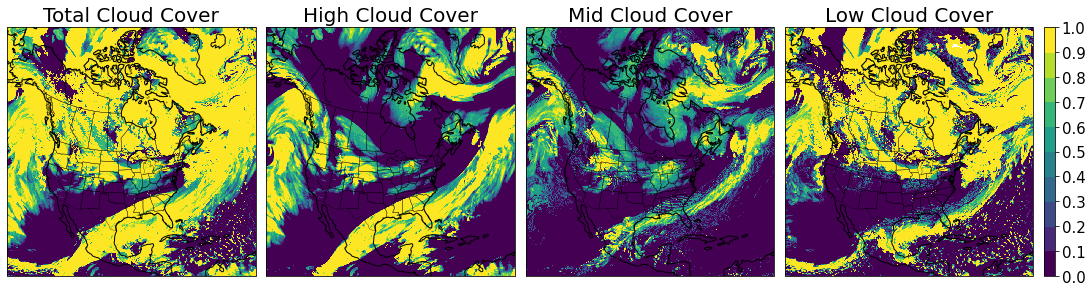

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 655
<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 655
<class 'netCDF4._netCDF4.Variable'>
float32 Tot_cloud_cover(lat, lon)
unlimited dimensions: 
current shape = (655, 655)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 High_cloud_cover(lat, lon)
unlimited dimensions: 
current shape = (655, 655)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 Mid_cloud_cover(lat, lon)
unlimited dimensions: 
current shape = (655, 655)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 Low_cloud_cover(lat, lon)
unlimited dimensions: 
current shape = (655, 655)
filling on, default _FillValue of 9.969209968386869e+36 used


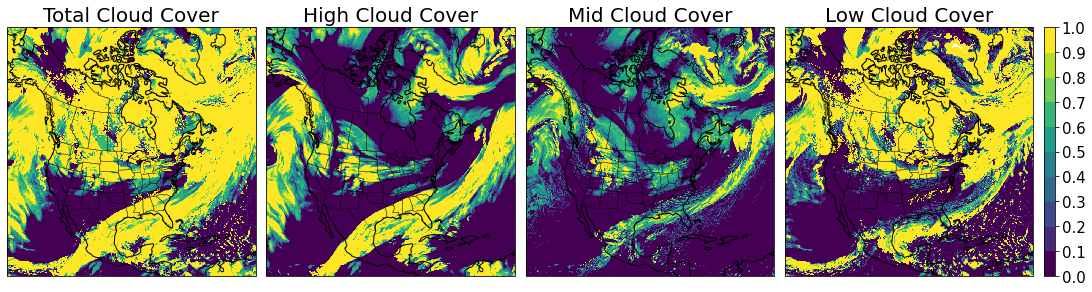

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 655
<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 655
<class 'netCDF4._netCDF4.Variable'>
float32 Tot_cloud_cover(lat, lon)
unlimited dimensions: 
current shape = (655, 655)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 High_cloud_cover(lat, lon)
unlimited dimensions: 
current shape = (655, 655)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 Mid_cloud_cover(lat, lon)
unlimited dimensions: 
current shape = (655, 655)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 Low_cloud_cover(lat, lon)
unlimited dimensions: 
current shape = (655, 655)
filling on, default _FillValue of 9.969209968386869e+36 used


KeyboardInterrupt: 

In [12]:
for i in range(len(df)):
    t_gem        = df['t_gem'   ][i]
    YYYY_gem     = str(df['date_gem'][i])[0:4]
    YYYYMMDD_gem = str(df['date_gem'][i])
    YYYYMM_gem   = str(df['date_gem'][i])[0:6]
    date         = str(df['date'    ][i])
    MM           = str(df['date_gem'][i])[4:6]

    pm       = "pm2013010100"
    gemname  = "COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes"

    filepath_COSP = config['COSP2']['input'] + "/YYYYMM/yyyymmddhh00.nc".format(gemname)
    ncfilei       = filepath_COSP.replace('YYYYMM',YYYYMM_gem).replace('yyyymmddhh00',YYYYMMDD_gem + str(t_gem).zfill(2) + '00')
    nc_not_exist  = '/pampa/poitras/DATA/COSP2/COSPIN/COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes/201401/201401051500.nc'
    if ncfilei == nc_not_exist:
        pass
    else:
        Tot_cloud_cover, High_cloud_cover, Mid_cloud_cover, Low_cloud_cover = compute_cloud_cover(ncfilei, layerdef)
        # Output data
        YYYYMM    = os.path.basename(os.path.dirname(ncfilei))
        ncfileo = dirout + '/' + YYYYMM_gem + '/' + os.path.basename(ncfilei)  
        create_ouput_file(ncfilei, ncfileo, Tot_cloud_cover, High_cloud_cover, Mid_cloud_cover, Low_cloud_cover, layerdef)
    